# Affinity
Given the transnational nature of terrorist networks, cooperation is crucial amongst counterterrorism bodies of various objectives and governing bodies. However, cooperation imposes its own set of bureaucratic costs, making it difficult to always carry out in practice. Therefore, effective counterterrorism should seek to strike a balance between too much and too little cooperation with external groups. Too little results in lost opportunities, but too much becomes cumbersome and unhelpful. 

In this notebook, we seek to develop a measure of similarity of terrorist attacks across differet traits of interest. For example, it is useful to understand which terrorist organizations are most similar. By quantifying similarity, instead of just offering a qualitative analysis, we can aid organizations seeking to find the *best* cooperative partners by examining groups whose challenges are similar to their own. For example, Boko Haram and Al Qaeda are very similar, we would recommend that groups interested in countering either of the two groups share observations about attack types, organizational structure, etc. 

## Preprocessing

First, let's load the data from before.

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from scipy.spatial.distance import cdist

In [154]:
import shelve 

#load up intermediate results from counter_terrorism_nb1
with shelve.open('intermediate_results/vars1') as db:
    top_terror_groups = db['top_terror_groups']

In [5]:
from preprocess_functions import load_data_relevant_cols, get_dummies

In [6]:
raw = load_data_relevant_cols()

/Users/akhiljalan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (4,6,8,10,11,12,17,18,24,29,31,33,35,37,38,39,41,43,45,46,47,49,51,53,54,55,57,58,59,60,61,62,63,64,73,76,79,82,84,86,88,90,92,94,96,97,106,108,114,115,121,123,125,126,127,128,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/akhiljalan/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (6,61,62,63,79,94,96,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Even after eliminating useless attributes in our preprocessing, we still have a variety of traits in our data which we can use to inform a similarity measure. 

In [60]:
raw.columns.values

array(['iyear', 'imonth', 'iday', 'country', 'country_txt', 'region',
       'region_txt', 'provstate', 'city', 'latitude', 'longitude',
       'specificity', 'success', 'attacktype1', 'attacktype1_txt',
       'targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt',
       'natlty1', 'natlty1_txt', 'gname', 'motive', 'weaptype1',
       'weaptype1_txt', 'weapsubtype1', 'weapsubtype1_txt', 'nkill',
       'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'property',
       'propextent', 'propextent_txt', 'propvalue', 'propcomment',
       'ransom', 'ransomamt'], dtype=object)

## Distance Mapping

We want to create a measure of similarity between different terrorist attacks. Given that we have already created a vector representation of the data using a one-hot encoding, a natural way to measure distance is the Euclidean distance on $\mathbb{R}^{n}$, or the $\ell_2$ distance. This distance corresponds to the physical distance between points in space. Formally, if $\vec{x}, \vec{y} \in \mathbb{R}^{n}$, then $$d(\vec{x}, \vec{y}) = \| \vec{x} - \vec{y} \|_2$$

Note the following:

1. For computational efficiency, we compute the distance of the means of the sub-groups rather than the average of pair-wise distances between each subgroup. Given that our dataset has over 170,000 attacks, the latter would be far too expensive to be feasible. 

2. Despite the fact that we are using a heatmap, we are interested in *lower values*, not higher ones. This is because high values indicate a larger distance than smaller ones. 


3. The matrix is symmetric, so looking either the upper or the lower triangular half is all that is needed. This follows from the symmetry property of distance - formally, for any points $i, j$, the distance $d(i, j)$ and $d(j, i)$ are equal. Also, $d(i, i) = 0$ for all $i$. 

4. One of the arguments in the function below is ```percentile_cutoff```, which corresponds to the percentage of distance values that we want to display. Displaying distances below a certain percentile makes the heatmaps easier to read, as the goal of these is to explore which subsets of the data are most similar to one another. 

Because this is simply exploratory analysis, we will simplify the similar measure to only look at a few key attributes. Using the ```get_dummies``` function from ```preprocess_functions.py```, we will create a one-hot encoding of the terrorist attack data with respect to these traits, and then use the discussed $\ell_2$ distance in $\mathbb{R}^{n}$ for measuring how "similar" two attacks are to one another. 

In [37]:
traits_to_compare = ['region_txt', 'targtype1_txt', 'weaptype1_txt', 
                     'iyear', 'nkill', 'natlty1_txt', 'gname']
dummies = get_dummies(raw, traits_to_compare)

In [144]:
def plot_affinity_heatmap(trait_str, attribute, colormap='RdYlBu', percentile_cutoff = 20):     
    trait_labels = [label for label in dummies.columns.values if trait_str in label]
    #remove 'unknown' and 'other' categories
    trait_labels = [label for label in trait_labels if label not in [trait_str + 'Unknown', trait_str + 'Other']]
    
    #calculate means for each category 
    means = []
    for label in trait_labels: 
        means.append(np.mean(dummies[dummies[label] == 1]).drop(index=trait_labels))
    
    #calculate distances and cutoff
    distances = cdist(means, means)
    cutoff = np.percentile(distances, q=percentile_cutoff)
    
    #initialize the figure and make plot labels
    plt.figure(figsize=(12, 8))
    plot_labels = [label.replace(trait_str, '') for label in trait_labels]
    plot_labels = [label.split('(')[0] for label in plot_labels]
    
    #plot the heatmap
    mask_df = pd.DataFrame(distances > cutoff)
    sns.heatmap(distances, cmap=colormap, xticklabels=plot_labels, 
                yticklabels=plot_labels, annot=True, mask=mask_df)
    title_txt = 'Divergence of mean terrorist attack by {}'.format(attribute) 
    if int(percentile_cutoff) != 100: 
        title_txt += ': Most Similar {} Percent'.format(int(percentile_cutoff))
    plt.title(title_txt)

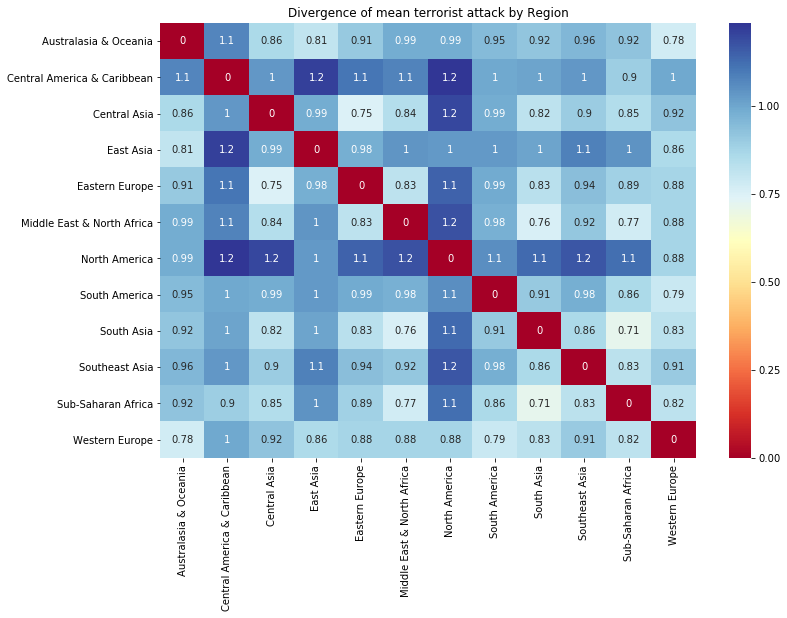

In [145]:
plot_affinity_heatmap('region_txt_', 'Region', percentile_cutoff=100)

Notably, there isn't much variation across regions even when using a multi-attribute measure such as the vectorized Euclidean distance. This seems to be further evidence of our speculation from ```counter_terrorism_nb1``` - terrorist attacks are not that different from region to region, at least according to our particular measure. We already observed this in the case of percentage of successful attacks.

Next, let's display only the top 30% of cells from the previous heatmap, to get a sense of which regions are the most similar to one another. 

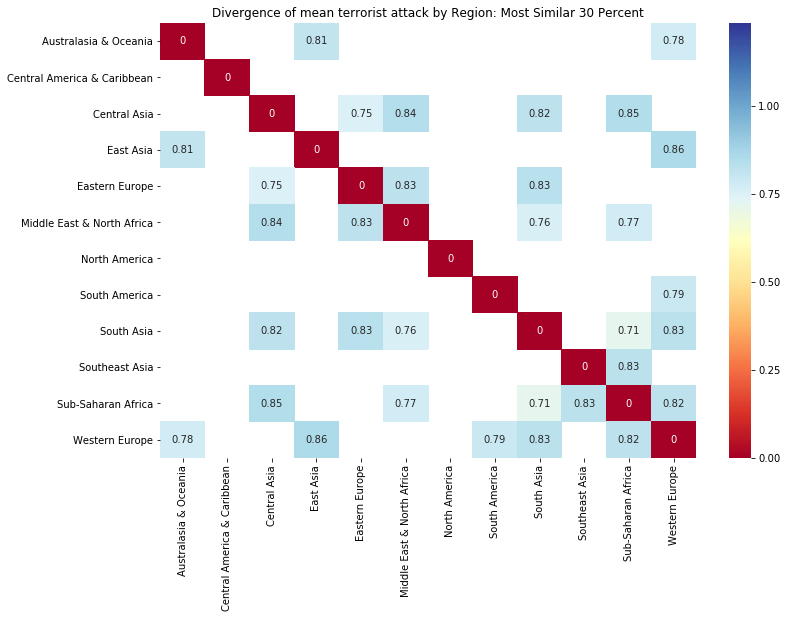

In [146]:
plot_affinity_heatmap('region_txt_', 'Region', percentile_cutoff=30)

Next, let's repeat this kind of experiment for other attributes of interest.

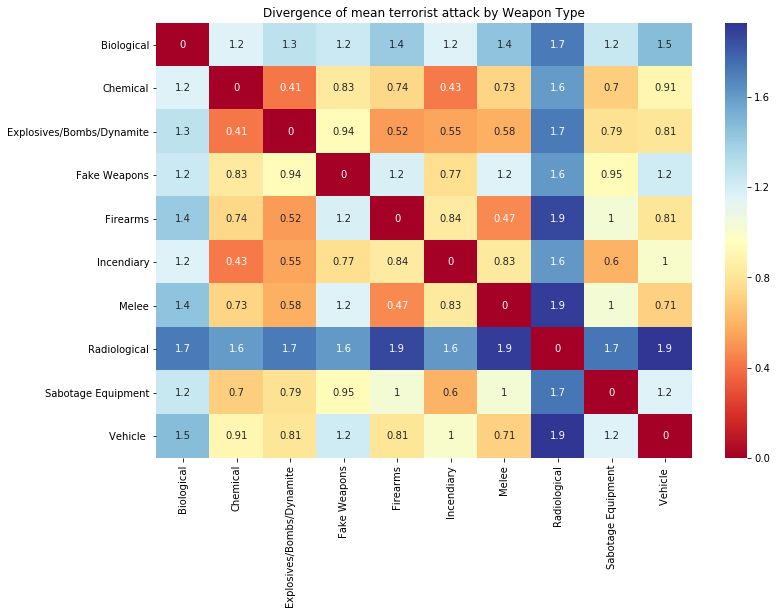

In [147]:
plot_affinity_heatmap('weaptype1_txt_', attribute='Weapon Type', percentile_cutoff=100)

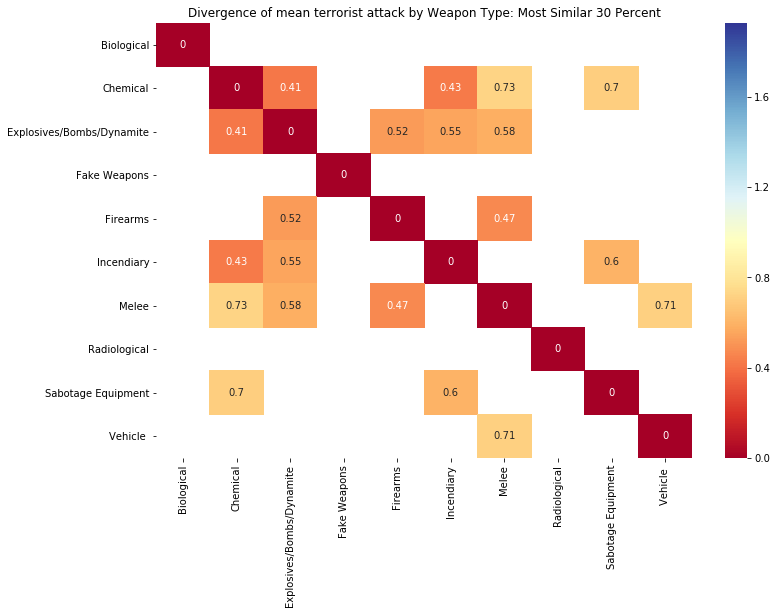

In [148]:
plot_affinity_heatmap('weaptype1_txt_', 'Weapon Type', percentile_cutoff=30)

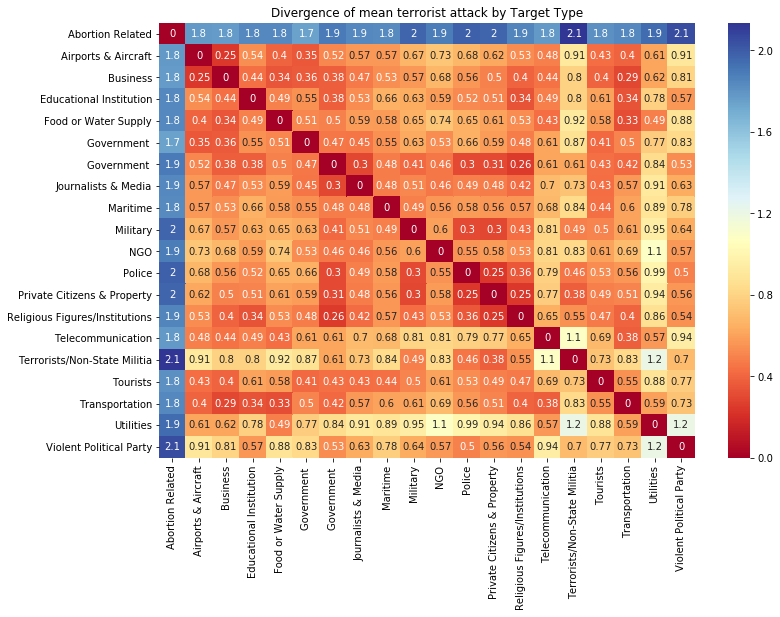

In [151]:
plot_affinity_heatmap('targtype1_txt_', attribute='Target Type', percentile_cutoff=100)

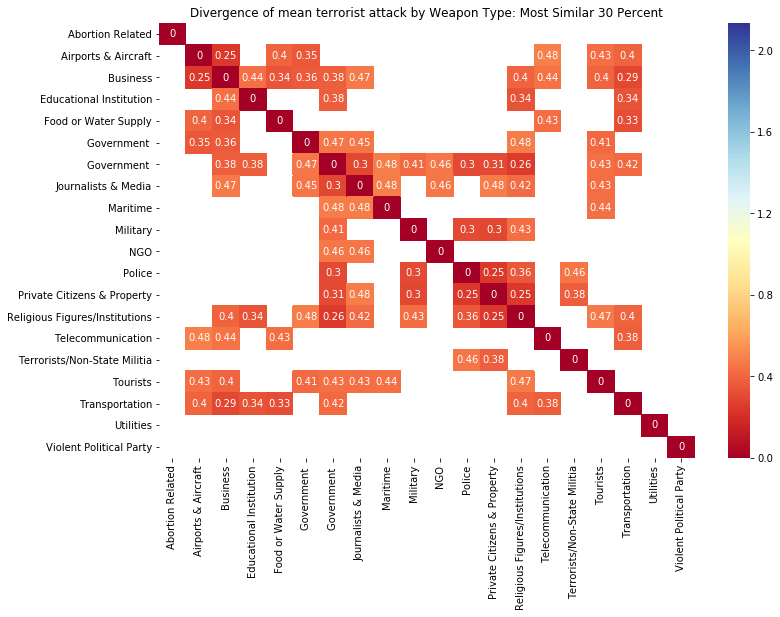

In [152]:
plot_affinity_heatmap('targtype1_txt_', attribute='Weapon Type', percentile_cutoff=30)

These affinity maps indicate several potential avenues of collaboration - for example, anti-explosive and anti-chemical weapons teams ought to compare their observations on execution strategies for these attacks, since they seem to be quite similar. 

### Detour: Explaining Abortion Attacks

In the heatmap above, we saw that abortion-related terrorist attacks sharply diverge from other kinds of attacks. To try to explain why, we'll re-examine the data from a hypothesis testing 

In [108]:
abortion_attacks = raw[raw['targtype1_txt'] == 'Abortion Related']
abortion_attacks.head()

In [112]:
abortion_attacks[abortion_attacks['region_txt'] != 'North America']

,iyear,imonth,iday,country,country_txt,region,region_txt,provstate,city,latitude,...,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ransom,ransomamt
11135,1980.0,6.0,14.0,362.0,West Germany (FRG),8.0,Western Europe,Bremen,Bremen,53.074981,...,NaN,NaN,NaN,1.0,4.0,Unknown,NaN,NaN,0.0,NaN
11152,1980.0,6.0,16.0,362.0,West Germany (FRG),8.0,Western Europe,Bremen,Bremen,53.074981,...,NaN,NaN,NaN,1.0,4.0,Unknown,NaN,NaN,0.0,NaN
11161,1980.0,6.0,17.0,362.0,West Germany (FRG),8.0,Western Europe,Hamburg,Hamburg,53.553813,...,1.0,NaN,NaN,1.0,4.0,Unknown,NaN,NaN,0.0,NaN
19983,1983.0,10.0,21.0,11.0,Argentina,3.0,South America,Buenos Aires,Buenos Aires,-34.603700,...,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN
55079,1994.0,2.0,11.0,603.0,United Kingdom,8.0,Western Europe,Northern Ireland,Belfast,54.597269,...,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN


In [113]:
abortion_attacks

,iyear,imonth,iday,country,country_txt,region,region_txt,provstate,city,latitude,...,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ransom,ransomamt
4471,1977.0,2.0,23.0,217.0,United States,1.0,North America,Minnesota,St. Paul,44.943829,...,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),250000.0,NaN,0.0,NaN
4670,1977.0,5.0,1.0,217.0,United States,1.0,North America,Vermont,Burlington,44.475920,...,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),100000.0,Building destroyed,0.0,NaN
5104,1977.0,8.0,18.0,217.0,United States,1.0,North America,Nebraska,Omaha,41.260675,...,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),35000.0,NaN,0.0,NaN
5427,1977.0,11.0,0.0,217.0,United States,1.0,North America,Ohio,Cincinnati,39.103175,...,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),4000.0,NaN,0.0,NaN
5696,1978.0,1.0,8.0,217.0,United States,1.0,North America,Ohio,Columbus,39.961960,...,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),200000.0,Building destroyed,0.0,NaN
5817,1978.0,2.0,0.0,217.0,United States,1.0,North America,Ohio,Cincinnati,39.103175,...,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),3000.0,NaN,0.0,NaN
5900,1978.0,2.0,18.0,217.0,United States,1.0,North America,Ohio,Cleveland,41.504365,...,1.0,1.0,0.0,1.0,3.0,Minor (likely < $1 million),100000.0,Building destroyed,0.0,NaN
5981,1978.0,3.0,1.0,217.0,United States,1.0,North America,Ohio,Akron,41.084195,...,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),NaN,NaN,0.0,NaN
6265,1978.0,5.0,15.0,217.0,United States,1.0,North America,Vermont,Burlington,44.475920,...,0.0,0.0,0.0,1.0,3.0,Minor (likely < $1 million),NaN,Outside of clinic scorched,0.0,NaN
6377,1978.0,6.0,15.0,217.0,United States,1.0,North America,Iowa,West Des Moines,41.590660,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN


In [118]:
# todo: 
'''1. Preprocess the data so that it scales uniformly. Remember sqrt(2) rule 
2. k-means
3. normal clustering (DB-SCAN because of sparsity?)
4. SVM
5. k-nearest neighbors 
6. sensitivity analysis'''

l1 = ['unknown', 'hello']
l2 = ['unknown']
# [arg for arg in l1 if arg not in l2]

['hello']

In [127]:
arr1 = np.random.randn(10, 5)
arr2 = np.random.randn(10, 5)
distances = cdist(arr1, arr2)
np_cutoff = np.percentile(distances, q=30)
distances > np_cutoff
dist_df = pd.DataFrame(distances)
cutoff = dist_df.quantile(q=0.3)
dist_df > cutoff

,0,1,2,3,4,5,6,7,8,9
0,True,True,True,True,True,True,True,True,True,True
1,False,True,False,True,True,True,True,True,False,False
2,True,False,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True
4,True,True,False,False,True,False,False,False,False,True
5,False,False,False,True,True,False,False,True,True,False
6,True,True,True,True,False,True,True,False,False,True
7,False,True,True,False,False,True,True,True,True,True
8,True,False,True,True,True,True,True,True,True,True
9,True,True,True,False,False,False,False,False,True,False


array([[False,  True,  True,  True, False,  True,  True,  True,  True,
         True],
       [False,  True, False,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True, False,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True, False,  True,  True,  True,  True,
         True],
       [ True,  True, False, False, False,  True, False, False, False,
         True],
       [False, False,  True,  True, False, False, False,  True,  True,
        False],
       [ True,  True,  True, False, False,  True,  True, False, False,
         True],
       [False,  True,  True, False, False,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True, False,  True, False,  True,  True,
         True],
       [ True,  True,  True, False, False,  True, False,  True,  True,
         True]], dtype=bool)

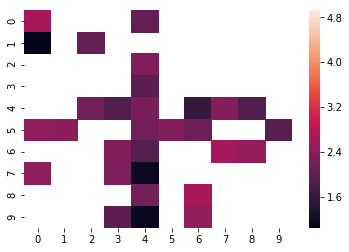

In [130]:
sns.heatmap(distances, mask=distances > np_cutoff)

In [133]:
'hello ( )'.split('(')[0]

'hello '